In [1]:
import numpy as np 
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
from numpy import genfromtxt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import ipywidgets as widgets
from ipywidgets import interactive
from sklearn.datasets import load_boston
import seaborn as sns

# Orthogonal Matching Pursuit for Outlier Removal on a 1D Data Set

  The first portion of this assignemnts introduces a basic example of using OMP for outlier removal using a simple linear data set. Using the provided functions, you will visualize a dataset with outliers and answer the following questions. The second task is to code the OMP Greedy Algorithm from scratch using only numpy functions and native python functions. This will then be used for the rest of the assignment so be sure that your algorithm works for the dummy dataset.
  
Recall that the pseudocode for OMP is provided for you in the note/lecture slides as well as the mathematical intuition behind the algorithm. Your goal here is to implement this algorithm on a dummy dataset for easy visualization and testing, and then to a real multidimensional data set. 

# Outlier Detection on Dummy Data

In [2]:
# Provided function for generating a dummy set 
def generate_data(n, d, num_outliers): # Code from HW2 Prob 5 OMP Outlier Removal for CS 189
    """
    Generates the data for our problem.
    
    args:
      n: number of samples
      d: dimension of samples
      num_outliers: how many outliers are in the noisy observations;
        we model outliers by adding large Gaussian noise
                      
    returns:
      data: the nxd data matrix X
      w_star: the underlying dx1 matrix W
      observations: nx1 vector of noisy observations with outliers
      
    """
    
    w_star = np.random.uniform(2.0,20.0,(d,1))
    data = np.random.uniform(0.0,10.0,(n,d))
    y_true = np.dot(data,w_star)
    ind = np.random.choice(np.arange(n), num_outliers, False)
    vec = 0.1*np.ones((n,1))
    for a in ind:
        vec[a] = 100.000
    observations = np.random.multivariate_normal(
                        np.ndarray.flatten(y_true), np.diagflat(vec))
    for a in ind:
        observations[a] += 40.000
    return data, w_star, observations


## Visualize dummy data
Using the function above that is taken from CS189 HW2 Q5: 
1. Generate a dataset of 50 points that is one dimensional so that you can visualize the graph. Then you can choose the inital number of outliers to anything between 1-20. 
2. Then using the sklearn library imported above split the data into a 80 percent size training set and a 20 percent size testing set. The students may choose whether to use the built in sklearn function or select the data themselves. 
3. Visualize the scatter plot of the training data
4. Train a Linear Regression model on the training data and plot the learned function.

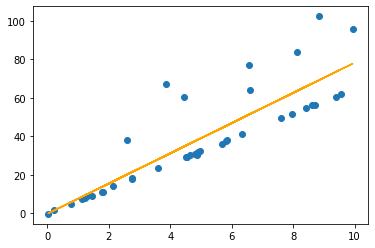

In [3]:
# TODO:
n = 50
d = 1
num_outliers = # Number of outliers
X, w_star, y = # Get data
X_train, X_test, y_train, y_test = # Split training and test

# TODO: Plot X_train vs y_train in a scatter plot, train a model on this data and plot its predicted line

## Implementing OMP Algorithm
In your plot, you should see that your learned function doesn't fit your true linear function exactly - it is being skewed by the outliers. In the lecture and note, we learned how OMP can be used for outlier detection. To help find a better regression line, we will utilize OMP on the dummy dataset.

**Implement the OMP algorithm below.** The inputs and outputs have already been defined for you so all you have to code is the algorithm itself. For this part, **DO NOT USE: sklearn's OMP algorithm**. Only use numpy and native python functions to code the entirety of the algorithm. 

In [4]:
def omp_outlier_detection(X, y, k, threshold=0):
  # Input:
  #   X: Features of data to run outlier detection on
  #   y: Labels of data to run outlier detection on
  #   k: Sparsity (How many outliers to detect)
  # Output:
  #   F: Array of indices of outliers

  # TODO: Implement OMP

Below we have provided the necessary code to interactively plot your data and show the outlier removal process as the sparisty value or k is changed in the process. The graphs that are produced will have associated questions. 

In [ ]:
def generate_num_outliers():
    return widgets.IntSlider(
        value=0,
        min=0,
        max=50,
        step=1,
        description='Sparisty k',
        continuous_update=False)

def visualize_OMP(k):
  F = omp_outlier_detection(X_train, y_train, k)
  outlierArray = X_train[F]
  outlierValues = y_train[F]
  plt.figure(1)
  data1 = plt.scatter(X_train, y_train, color = 'blue')
  data2 = plt.scatter(outlierArray, outlierValues, color = 'red')
  plt.legend((data1, data2), ('True Function', 'Outliers'))
  plt.xlabel("X Data")
  plt.ylabel("Y Data")
  plt.title("Graph before OMP")

  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_train)
  plt.plot(X_train, y_pred, color='orange')

  ## Second Plot without the outliers showing
  plt.figure(2)
  removedX = np.delete(X_train, F).reshape(-1, 1)
  removedY = np.delete(y_train, F)
  data3 = plt.scatter(removedX, removedY, color = 'green')

  omp_model = LinearRegression()
  omp_model.fit(removedX, removedY)
  y_pred = omp_model.predict(removedX)
  plt.plot(removedX, y_pred, color='orange')

  plt.title("Graph after OMP")
  plt.xlabel("X Data")
  plt.ylabel("Y Data")
  #plt.legend((data3), ('Resultant Function'))

interactive_plot = interactive(visualize_OMP,
                               k=generate_num_outliers())
interactive_plot


interactive(children=(IntSlider(value=0, continuous_update=False, description='Sparisty k', max=50), Output())…

From the Graphs Above answer the following question: 
1. **What occurs when the number of k outliers are removed? What happens if this is too high or too low in comparison to the number of actual outliers present?** <br>


---


ANSWER: ...

# Outlier Detection on the Forest Fires Dataset

Now we will attempt to use OMP outlier detection on a real dataset; we will be working with Forest Fire Dataset sourced from UCI's machine learning data sets. The nature of this dataset is as follows:

>There are 517 different data points in this data set that contribute to our X. Each of these datapoints contain 13 features or attributes: The x,y position of the fire in the park, month, day, FFMC, DMC, DC, ISI, temperature, Relative Humidity, Wind, Rain, and our output parameter as the area burned by the fire.

We have imported the dataset below for you using the pandas dataframe. You must preprocess the data in the following way.
# Preprocessing
1. Cut out the X, Y position of the fire attributes, because we don't believe position within the park will be a significant factor of burned area.
2. Choose the most correlated features with respect to area.
2. Label and One-hot Encoded the Month and Day of the fire.
3. Standard scale the features.

In [ ]:
url = 'https://raw.githubusercontent.com/aparande/EECS189-OMP-Assignment/main/Jupyter%20Assignment/forestfires.csv?token=ACTEYP6ONZJ5E26S3PZYJIK7ZFYMM'
df1 = pd.read_csv(url)
df1

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


### Correlations
We will now inspect the features and see if there are any we can remove. Using the correlation matrix print out the heat map of the features.

In [5]:
# TODO: Print out a heatmap of the correlation matrix for the features

**Observed Features:** <br>
From the heat map we can see that the highest correlated features by the numbers are clearly the Temperature, Relative Humidity, DMC. We will use these for our model, along with Month and Day.

In [ ]:
df1 = df1[['month', 'day', 'temp', 'RH', 'DMC', 'area']]

In [ ]:
# TODO: Split data into features and labels
Xb = # Features
yb = # Labels

In [ ]:
# One-hot encode and Standard Scale
Xb = pd.get_dummies(Xb, columns=['month', 'day'])
scaler = StandardScaler()
Xb = pd.DataFrame(scaler.fit_transform(Xb))

Let's plot some of the features vs area. How many outliers can you immediately identify?

In [8]:
# TODO: Plot features vs area

**Report your observations:** (Write your observations here)

## Your Turn: Perform OMP on this dataset
Steps
1. Split the dataset as you did before. **Use a random_state=189 for reproducability**.
2. Fit LR model to the training data and predict on the testing data and report the MSE of the entire dataset without removing any outliers. 
3. Perform OMP on the training set and then do the same thing an perform LR on the newly outlier free dataset. (Here select the number of data points removed to be low because the number of outliers in this set does not exceed 5)

In [ ]:
# TODO: split train test 
#***SOLUTION***
X_train, X_test, y_train, y_test = # Split data

# TODO: Perform Linear Regression and print the MSE

ypred = #...
MSE = #...
Rsquared = #...

MSE:  1030.0464905735284


In [ ]:
## TODO: Implement a function to delete and return your outlier free training set
def get_new_XY(Xnew, ynew, k):
  # Input:
  #   Xnew: Training Data to run outlier removal
  #   ynew: Labels of training data to run outlier detection on
  #   k: Sparsity (How many outliers to detect) (Recall <5)
  # Output:
  #   X_train_new: Outlier free feature training data
  #   y_train_new: Outlier free label training data

In [ ]:
## TODO: Create A prediction function for the outlier free data
def predict_new(X_train_new, y_train_new, xt, yt):
  # Input:
  #   X_train_new: Outlier free feature training data
  #   y_train_new: Outlier free label training data
  #   xt: Testing data to predict on
  #   yt: Testing data labels to predict on
  # Output:
  #   MSE: Mean Squared Error on the Test Set
  #   Rsquared : Correlation Coefficient on Test Set

Below is Code Given to you to see the effect of removing multiple outliers and the resultant MSE after a certain number of outliers are removed.

interactive(children=(IntSlider(value=0, continuous_update=False, description='Sparisty k', max=50), Output())…

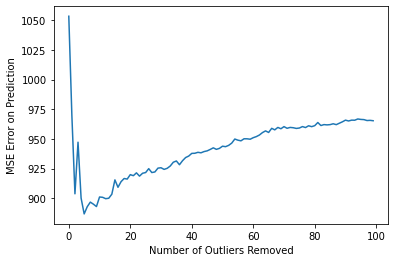

In [ ]:
mses = []
r2 = []
max_outlier = 100

curr_X_train = X_train.to_numpy()
curr_y_train = y_train.to_numpy()
for k in range(0, max_outlier):
  D = get_new_XY(curr_X_train, curr_y_train, k)
  errors = predict_new(D[0], D[1], X_test, y_test)
  mses.append((errors[0]))
  r2.append(errors[1])
ind = np.linspace(0, max_outlier-1, max_outlier)
msesArray = np.asarray(mses)
r2Array = np.asarray(r2)

plt.figure(1)
plt.plot(ind, msesArray)
plt.xlabel("Number of Outliers Removed")
plt.ylabel("MSE Error on Prediction")

def MSEInteractive(k):
  D = get_new_XY(curr_X_train, curr_y_train, k)
  errors = predict_new(D[0], D[1], X_test, y_test)
  mse = errors[0]
  print("MSE: ", mse)

interactiveMSE = interactive(MSEInteractive,
                               k=generate_num_outliers())
interactiveMSE


**Q: Your graph should have a steep drop and then a steady incline after. What is the approximate optimal number of outliers to remove? Why does the graph form this shape?**

A: (ANSWER HERE)



---



Remember that we used a random_state=189. Could our graph's nice shape be a fluke? Let's see if we can find situations in which our OMP outlier removal doesn't produce such a clean graph.

First, let's print out the top 10 datapoints which OMP is identifying as the biggest outliers in the entire dataset (before the split), along with their respective areas.

In [6]:
# TODO: Print outliers identified in OMP, along with their areas

**Q: Does these agree with your observations from the scatterplot visualization?**

A: (ANSWER HERE)

Now, let's inspect where these outliers landed once our data was split with random_state=189.

In [7]:
# TODO: Find out and print where our outliers have landed (training set or test set?)
# Hint: you can use a try/catch block with the .loc pandas function

**Q: In the current state all, most of the top outliers are present in the training set, why might this be advantageous considering the code you have written? For example if the testing set had the top two outliers what do you think will happen?**

A: (ANSWER HERE)

**Try running the above cells again with different random states for the training/test split. Observe how the graph changes when the top outliers are placed in the test set and record your observations below.**

**Observation:** (ANSWER HERE)